# Region K Means

In [1]:
from collections import defaultdict
import os
import sys
sys.path.append("../")

In [2]:
import spopt
from spopt import w_to_g

import libpysal
import geopandas
import networkx
import numpy

In [3]:
numpy.random.seed(12345)

In [4]:
w = libpysal.weights.lat2W(3,3)
data = numpy.random.normal(size=(w.n,3))

In [5]:
w.neighbors

{0: [3, 1],
 3: [0, 6, 4],
 1: [0, 4, 2],
 4: [1, 3, 7, 5],
 2: [1, 5],
 5: [2, 4, 8],
 6: [3, 7],
 7: [4, 6, 8],
 8: [5, 7]}

In [6]:
RKM = spopt.RegionKMeansHeuristic

In [7]:
model = RKM(data, 3, w)
model.solve()

In [8]:
dim = 10
w = libpysal.weights.lat2W(dim,dim)
data = numpy.random.normal(size=(w.n,3))
model = RKM(data, 20, w)
model.solve()

In [9]:
model.iters_

2

In [10]:
model.labels_

array([16, 16, 16, 16, 16,  6,  6,  6, 10, 10,  5,  5, 17, 17, 17, 17,  6,
        6,  6, 10,  5,  5, 17, 17, 12, 12, 14,  6, 10, 10,  8,  5, 12, 12,
       12, 14, 14, 14, 10, 10,  8,  8,  8, 11, 18, 18, 14, 14,  1,  1,  8,
        4, 11, 11, 11, 18, 18, 14,  1,  7,  4,  4,  4, 11, 11, 18, 18,  1,
        1,  7,  4,  4,  3,  3,  2,  2,  2, 13,  7,  7,  4,  9,  9,  2,  2,
       19, 19, 13, 13, 13,  9,  9,  9, 19, 19, 19, 19,  0, 15, 15])

In [11]:
numpy.unique(model.labels_).shape

(20,)

In [12]:
libpysal.weights.build_lattice_shapefile(dim, dim, "lattice.shp")

In [13]:
gdf = geopandas.read_file('lattice.shp')

<AxesSubplot:>

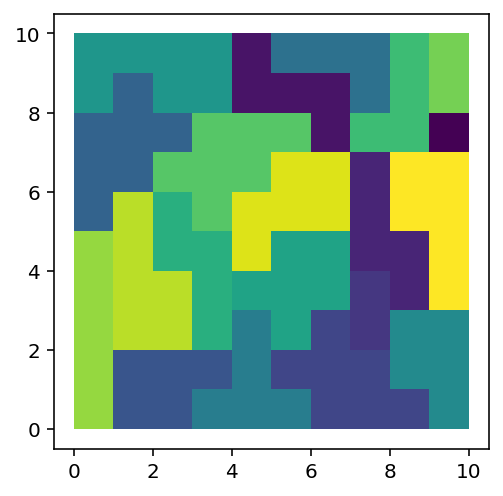

In [14]:
gdf['region'] = model.labels_
gdf.plot(column='region')

In [15]:
areas = numpy.arange(dim*dim)
regions = [areas[model.labels_==region] for region in range(20)]

In [16]:
regions

[array([97]),
 array([48, 49, 58, 67, 68]),
 array([74, 75, 76, 83, 84]),
 array([72, 73]),
 array([51, 60, 61, 62, 70, 71, 80]),
 array([10, 11, 20, 21, 31]),
 array([ 5,  6,  7, 16, 17, 18, 27]),
 array([59, 69, 78, 79]),
 array([30, 40, 41, 42, 50]),
 array([81, 82, 90, 91, 92]),
 array([ 8,  9, 19, 28, 29, 38, 39]),
 array([43, 52, 53, 54, 63, 64]),
 array([24, 25, 32, 33, 34]),
 array([77, 87, 88, 89]),
 array([26, 35, 36, 37, 46, 47, 57]),
 array([98, 99]),
 array([0, 1, 2, 3, 4]),
 array([12, 13, 14, 15, 22, 23]),
 array([44, 45, 55, 56, 65, 66]),
 array([85, 86, 93, 94, 95, 96])]

In [17]:
g = w_to_g(w)

In [18]:
for region in regions:
    print(region, networkx.is_connected(g.subgraph(region)))

[97] True
[48 49 58 67 68] True
[74 75 76 83 84] True
[72 73] True
[51 60 61 62 70 71 80] True
[10 11 20 21 31] True
[ 5  6  7 16 17 18 27] True
[59 69 78 79] True
[30 40 41 42 50] True
[81 82 90 91 92] True
[ 8  9 19 28 29 38 39] True
[43 52 53 54 63 64] True
[24 25 32 33 34] True
[77 87 88 89] True
[26 35 36 37 46 47 57] True
[98 99] True
[0 1 2 3 4] True
[12 13 14 15 22 23] True
[44 45 55 56 65 66] True
[85 86 93 94 95 96] True
